In [138]:
#add parent directory to sys.path to allow module imports
#see https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder/11158224#11158224
import sys
sys.path.insert(1,'..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
#import matplotlib.colors as colors
import os
import glob
import ternary
import helpers.fileload as fl
from helpers.calc_chemfeat import perovskite, formula_redfeat, formula_pif
from helpers.plotting import quat_slice_scatter, quat_slice_heatmap, add_colorbar, sliceformula_from_tuple, rescale_ticks
from helpers.predict import predict_from_pifs
from helpers.pickletools import save_pickle, load_pickle, pickle_dict
from citrination_client import CitrinationClient
from ternary.helpers import simplex_iterator
import pypif.pif

In [2]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/conductivity') #data/EIS_data
pifdir = os.path.join(datadir,'pifs')
plotdir = os.path.join(tcodir,'scripts/conductivity/plots')
client = client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')

## Predicted vs. actual plots for 3 sigma models

Show both log and linear scales

In [3]:
srcdir = os.path.join(pifdir,'Co(2,3)Fe(3,4)')
pifs = []
for file in glob.glob(os.path.join(srcdir,'*.json')):
    with open(file,'r') as f:
        fp = pypif.pif.load(f)
        pifs += fp

In [67]:
def loglin_pred_act_plots(results,xaxes,yaxes,color,figsize=(12,10),fs=12,axpad=0.05):
    fig, axes = plt.subplots(2,2,figsize=figsize)
    
#     xlabels = np.array([['ASR','ASR'],['log(ASR)','log(ASR)']])
#     ylabels = np.array([['Predicted ASR\n(from log model)','Predicted ASR'],
#                         ['Predicted log(ASR)','Predicted log(ASR)\n(from linear model)']])

    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            ax = axes[i,j]
            xax = xaxes[i,j]
            yax = yaxes[i,j]
#             xlab = xlabels[i,j]
#             ylab = ylabels[i,j]
            ax.scatter(results[xax],results[yax],s=15,c=results[color])
            
            axmin = min(results[xax].min(),results[yax].min())
            axmax = max(results[xax].max(),results[yax].max())
            axispad = (axmax-axmin)*axpad
#             xrng = results[xax].max() - results[xax].min()
#             xlim = (results[xax].min()-limpad*xrng, results[xax].max()+limpad*xrng)
#             yrng = results[yax].max() - results[yax].min()
#             ylim = (results[yax].min()-limpad*yrng, results[yax].max()+limpad*yrng)
            axlim = [axmin-axispad, axmax+axispad]
            #print(axmin,axmax,axpad,axlim)
            
            ax.plot(ax.get_xlim(),ax.get_xlim(),c='gray')
            ax.set_xlim(axlim)
            ax.set_ylim(axlim)
            ax.set_xlabel(xax,size=fs)
            ax.set_ylabel(yax,size=fs)

    add_colorbar(fig=fig,ax=axes,subplots_adjust={},vmin=results[color].min(),vmax=results[color].max(),
                label=color,cbrect=[0.85,0.12,0.02,0.76],labelkwargs={'size':fs,'labelpad':10},
                tickparams={'labelsize':fs-2})
    
    return fig, axes

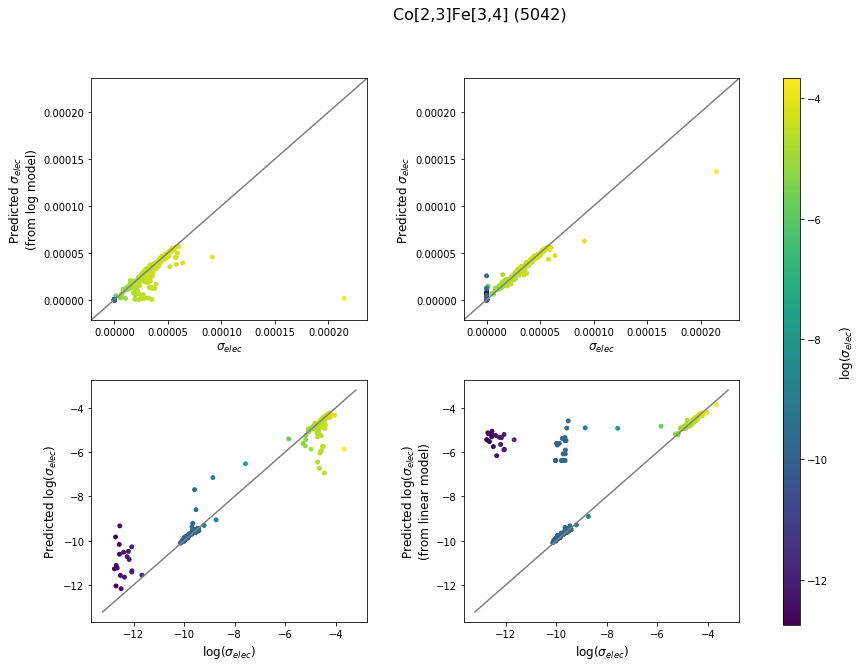

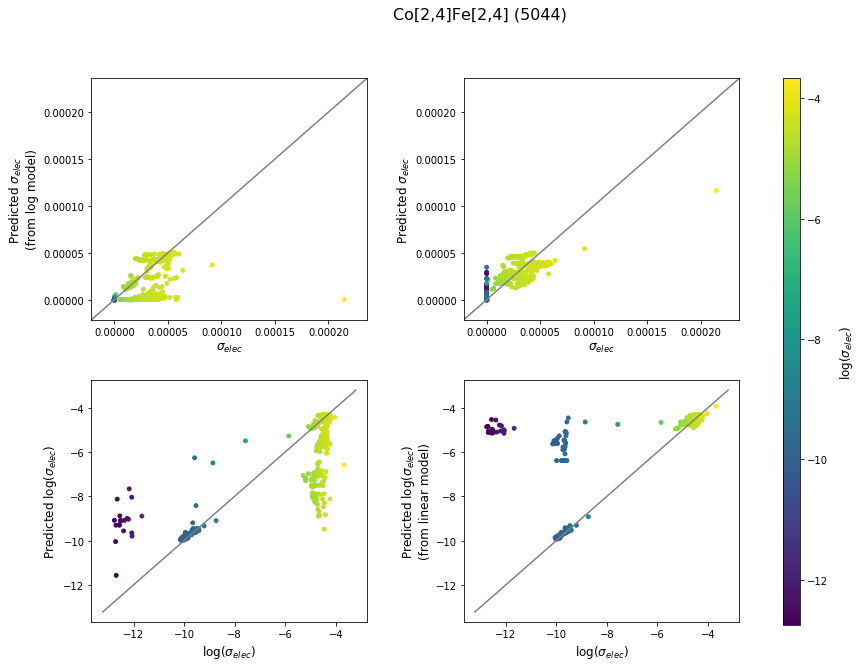

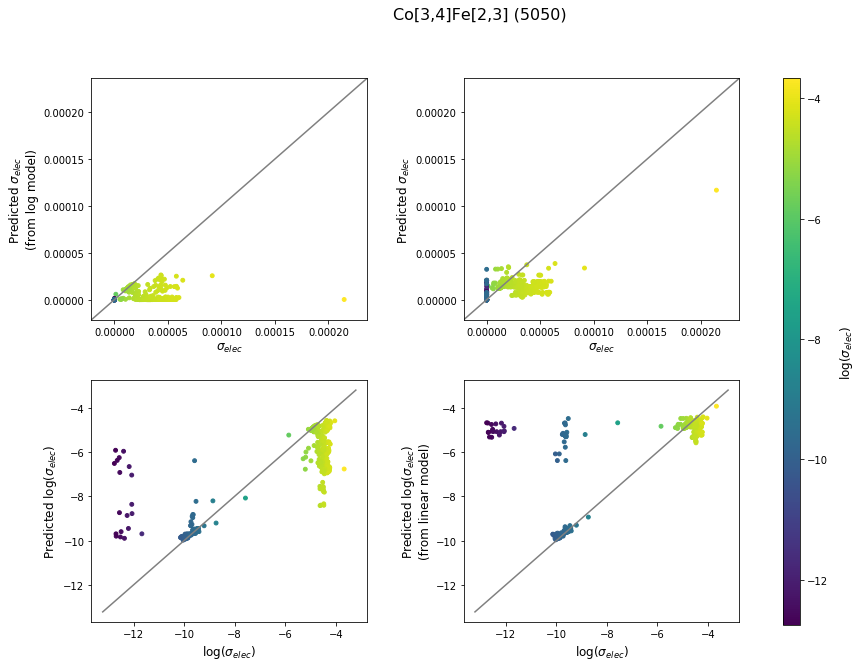

In [68]:
view_ids = [5042,5044,5050]
view_labels = ['Co[2,3]Fe[3,4] (5042)','Co[2,4]Fe[2,4] (5044)','Co[3,4]Fe[2,3] (5050)']
predict=['sigma_e','log_sigma_e']
#exclude=['formula']
condition = {'Atmosphere':'dry','Temperature ($^\circ$C)':437}
for (view_id,label) in zip(view_ids,view_labels):
    result = predict_from_pifs(view_id=view_id,pifs=pifs,predict=predict,exclude=exclude,condition=condition)
    result['Predicted log($\sigma_{elec}$)\n(from linear model)'] = np.log10(result['pred_sigma_e'])
    result['Predicted $\sigma_{elec}$\n(from log model)'] = 10**(result['pred_log_sigma_e'])
    rename = {'log_sigma_e':'log($\sigma_{elec}$)','sigma_e':'$\sigma_{elec}$',
              'pred_log_sigma_e':'Predicted log($\sigma_{elec}$)', 'pred_sigma_e':'Predicted $\sigma_{elec}$'}
    res_renamed = result.rename(columns=rename)
    
    xaxes = np.array([['$\sigma_{elec}$','$\sigma_{elec}$'],['log($\sigma_{elec}$)','log($\sigma_{elec}$)']])
    yaxes = np.array([['Predicted $\sigma_{elec}$\n(from log model)','Predicted $\sigma_{elec}$'],
                     ['Predicted log($\sigma_{elec}$)','Predicted log($\sigma_{elec}$)\n(from linear model)']])
    fig, axes = loglin_pred_act_plots(res_renamed,xaxes,yaxes,color='log($\sigma_{elec}$)',axpad=0.1)
    fig.suptitle(label,fontsize=16)


## Ternary plots

Slices of quaternary space

In [49]:
pickledir = os.path.join(tcodir,'scripts/pickles')

def formula_input(formula,cat_ox_lims,red_feat=None):
    if red_feat is None:
        red_feat = formula_redfeat(formula,cat_ox_lims=cat_ox_lims)
    red_inp = {'Property {}'.format(k):v for (k,v) in red_feat.items()}
    base_inp = {'Atmosphere':'dry','Temperature ($^\circ$C)':473}
    inp_dict = {**base_inp,**red_inp}
    return inp_dict

def heatmap_inputs(cat_ox_lims,tuple_scale, pkl_dict=None, slice_axis='Y',slice_vals = [0,0.05,0.1],Ba = 0.9,tern_axes=['Co','Fe','Zr']):
    inputs = {}
    red_feat = {}
    for slice_val in slice_vals:
        for tup in simplex_iterator(scale=tuple_scale):
            formula = sliceformula_from_tuple(tup=tup,slice_val=slice_val,slice_axis=slice_axis,tern_axes=tern_axes,Ba=Ba)
            try:
                rf = pkl_dict.dict[formula]
            except KeyError:
                rf = formula_redfeat(formula,cat_ox_lims=cat_ox_lims)
                pkl_dict.dict[formula] = rf
            red_feat[formula] = rf
            inp_dict = formula_input(formula,cat_ox_lims,red_feat=rf)
            inputs[(slice_axis,slice_val,tup)] = inp_dict
            
    return inputs

def slicetup_lookup(tup,slice_axis,slice_val,dict):
    return dict[(slice_axis,slice_val,tup)]

def log_st_lookup(tup,slice_axis,slice_val,dict):
    return np.log10(slicetup_lookup(tup,slice_axis,slice_val,dict))

In [188]:
"calculate features/inputs for heatmaps"
# calc_feat_Co23Fe34 = pickle_dict(os.path.join(pickledir,'feat_Co23Fe34'))
# calc_feat_Co24Fe24 = pickle_dict(os.path.join(pickledir,'feat_Co24Fe24'))
# calc_feat_Co34Fe23 = pickle_dict(os.path.join(pickledir,'feat_Co34Fe23'))

################################################################
"""
IMPORTANT: order of tern_axes set here must match plots below!
tuple order: right, top, left
if tern_axes order needs to be changed:
    1. re-run this cell (should reuse features from pickles - formula is alpha ordered)
    2. re-run client predictions - even though formulas are same, order is different
"""
################################################################
#Y slices
calc_inp_Co23Fe34 = heatmap_inputs(cat_ox_lims={'Co':[2,3],'Fe':[3,4]}, slice_axis='Y', slice_vals=[0,0.05,0.1,0.2],
                                   tern_axes=['Co','Fe','Zr'],
                                   tuple_scale=20,pkl_dict=calc_feat_Co23Fe34)
calc_inp_Co24Fe24 = heatmap_inputs(cat_ox_lims={'Co':[2,4],'Fe':[2,4]}, slice_axis='Y', slice_vals=[0,0.05,0.1,0.2],
                                   tern_axes=['Co','Fe','Zr'],
                                   tuple_scale=20,pkl_dict=calc_feat_Co24Fe24)
calc_inp_Co34Fe23 = heatmap_inputs(cat_ox_lims={'Co':[3,4],'Fe':[2,3]}, slice_axis='Y', slice_vals=[0,0.05,0.1,0.2],
                                   tern_axes=['Co','Fe','Zr'],
                                   tuple_scale=20,pkl_dict=calc_feat_Co34Fe23)

#Zr slices
sliceZr_inp_Co23Fe34 = heatmap_inputs(cat_ox_lims={'Co':[2,3],'Fe':[3,4]}, slice_axis='Zr', slice_vals=[0.1,0.3,0.5,0.8],
                                      tern_axes=['Co','Fe','Y'],
                                      tuple_scale=20,pkl_dict=calc_feat_Co23Fe34)
sliceZr_inp_Co24Fe24 = heatmap_inputs(cat_ox_lims={'Co':[2,4],'Fe':[2,4]}, slice_axis='Zr', slice_vals=[0.1,0.3,0.5,0.8],
                                      tern_axes=['Co','Fe','Y'],
                                      tuple_scale=20,pkl_dict=calc_feat_Co24Fe24)
sliceZr_inp_Co34Fe23 = heatmap_inputs(cat_ox_lims={'Co':[3,4],'Fe':[2,3]}, slice_axis='Zr', slice_vals=[0.1,0.3,0.5,0.8],
                                      tern_axes=['Co','Fe','Y'],
                                      tuple_scale=20,pkl_dict=calc_feat_Co34Fe23)

calc_inp_Co23Fe34.update(sliceZr_inp_Co23Fe34)
calc_inp_Co24Fe24.update(sliceZr_inp_Co24Fe24)
calc_inp_Co34Fe23.update(sliceZr_inp_Co34Fe23)

calc_feat_Co23Fe34.update_file()
calc_feat_Co24Fe24.update_file()
calc_feat_Co34Fe23.update_file()

Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co23Fe34
Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co24Fe24
Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co34Fe23


In [63]:
#calc_inp dicts didn't have slice_axis in keys originally - need to add to keys and combine dicts for different slice axes
def convert_dict(cdict,slice_axis):
    return {(slice_axis,)+k:v for (k,v) in cdict.items()}

"add slice_axis to dict keys"
#calc_inp_Co23Fe34 = convert_dict(calc_inp_Co23Fe34,slice_axis='Y')
#calc_inp_Co24Fe24 = convert_dict(calc_inp_Co24Fe24,slice_axis='Y')
#calc_inp_Co34Fe23 = convert_dict(calc_inp_Co34Fe23,slice_axis='Y')
# sliceZr_inp_Co23Fe34 = convert_dict(sliceZr_inp_Co23Fe34,slice_axis='Zr')
# sliceZr_inp_Co24Fe24 = convert_dict(sliceZr_inp_Co24Fe24,slice_axis='Zr')
# sliceZr_inp_Co34Fe23 = convert_dict(sliceZr_inp_Co34Fe23,slice_axis='Zr')
"add Zr slice inputs to main dicts"
# calc_inp_Co23Fe34.update(sliceZr_inp_Co23Fe34)
# calc_inp_Co24Fe24.update(sliceZr_inp_Co24Fe24)
# calc_inp_Co34Fe23.update(sliceZr_inp_Co34Fe23)

In [189]:
"predict sigma"
#client can only process <1000 predictions at a time (not sure what the limit is; 600<lim<1000)
npred = 500
res_5042 = []
res_5044 = []
res_5050 = []
for i in range(int(np.ceil(len(calc_inp_Co23Fe34)/npred))):
    start = i*npred
    end = (i+1)*npred
    tres_5042 = client.predict(5042,list(calc_inp_Co23Fe34.values())[start:end])
    tres_5044 = client.predict(5044,list(calc_inp_Co24Fe24.values())[start:end])
    tres_5050 = client.predict(5050,list(calc_inp_Co34Fe23.values())[start:end])
    res_5042 += (tres_5042)
    res_5044 += (tres_5044)
    res_5050 += (tres_5050)

sigma_pred_5042 = [r.get_value('Property sigma_e').value for r in res_5042]
sigma_pred_5044 = [r.get_value('Property sigma_e').value for r in res_5044]
sigma_pred_5050 = [r.get_value('Property sigma_e').value for r in res_5050]

logsigma_pred_5042 = [r.get_value('Property log_sigma_e').value for r in res_5042]
logsigma_pred_5044 = [r.get_value('Property log_sigma_e').value for r in res_5044]
logsigma_pred_5050 = [r.get_value('Property log_sigma_e').value for r in res_5050]

#dicts for slicetup_lookup
sigma_5042_dict = dict(zip(calc_inp_Co23Fe34.keys(),sigma_pred_5042))
sigma_5044_dict = dict(zip(calc_inp_Co24Fe24.keys(),sigma_pred_5044))
sigma_5050_dict = dict(zip(calc_inp_Co34Fe23.keys(),sigma_pred_5050))

logsigma_5042_dict = dict(zip(calc_inp_Co23Fe34.keys(),logsigma_pred_5042))
logsigma_5044_dict = dict(zip(calc_inp_Co24Fe24.keys(),logsigma_pred_5044))
logsigma_5050_dict = dict(zip(calc_inp_Co34Fe23.keys(),logsigma_pred_5050))

In [91]:
#fixing up calc_inp dicts - hadn't defined formula_input properly
# for key,feat in calc_inp_Co34Fe23.items():
#     fp = {'Property {}'.format(k):v for (k,v) in feat.items() if k not in ['Atmosphere','Temperature ($^\\circ$C)']}
#     fp.update({'Atmosphere':'dry','Temperature ($^\circ$C)':473})
#     calc_inp_Co34Fe23[key] = fp

# for key,(formula,rf) in zip(calc_inp_Co23Fe34.keys(),calc_feat_Co23Fe34.dict.items()):
#     inp_dict = formula_input(formula,cat_ox_lims={'Co':[2,3],'Fe':[3,4]},red_feat=rf)
#     calc_inp_Co23Fe34[key] = inp_dict

In [156]:
#refresh modules
import sys
del sys.modules['helpers.plotting']
del quat_slice_scatter, quat_slice_heatmap, add_colorbar, sliceformula_from_tuple, rescale_ticks
from helpers.plotting import quat_slice_scatter, quat_slice_heatmap, add_colorbar, sliceformula_from_tuple, rescale_ticks

In [160]:
def pred_sigma_slice_plots(slice_axis,tern_labels,slice_vals,zdict,zfunc,title,logscale=False,vmin=None,vmax=None):
    fig, axes = plt.subplots(1,3,figsize=(20,6))
    if vmin is None:
        if zfunc == log_st_lookup:
            vmin = np.log10(min(zdict.values()))
        else:
            vmin = min(zdict.values())
    if vmax is None:
        if zfunc == log_st_lookup:
            vmax= np.log10(max(zdict.values()))
        else:
            vmax = max(zdict.values())
            
    print(vmin,vmax)

    for i,slice_val in enumerate(slice_vals):
        ax = axes[i]
        tax, vmin, vmax = quat_slice_heatmap(tuple_scale=20,zfunc=zfunc,slice_val=slice_val, tern_labels=tern_labels,
                                         vmin=vmin, vmax=vmax, ax=ax, 
                                         zfunc_kwargs={'dict':zdict,'slice_axis':slice_axis,'slice_val':slice_val},
                                         labelsize=15, multiple=(1-slice_val)/5, add_labeloffset=0.05,
                                         tick_kwargs={'tick_formats': '%.2g', 'offset': 0.03,'fontsize':11} )


        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.set_title('{} = {:.2g}'.format(slice_axis,slice_val),x=0.15,y=0.9,size=15,bbox=props)

    if logscale==True:
        cblabel = 'Predicted log($\sigma_{elec}$)'
        cbtickfmt = '%.1f'
    else:
        cblabel = 'Predicted $\sigma_{elec}$'
        cbtickfmt = '%.0e'
    add_colorbar(vmin=vmin,vmax=vmax,label=cblabel,labelkwargs={'size':16,'labelpad':10},
                 tickparams={'labelsize':12}, tickformat=cbtickfmt,cbrect=[0.9,0.18,0.02,0.53],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
    
    fig.suptitle(title,size='18')
    fig.subplots_adjust(top=0.7)
    
    return fig, axes


## Y slices

5.430368406545792e-07 4.896803306028625e-05


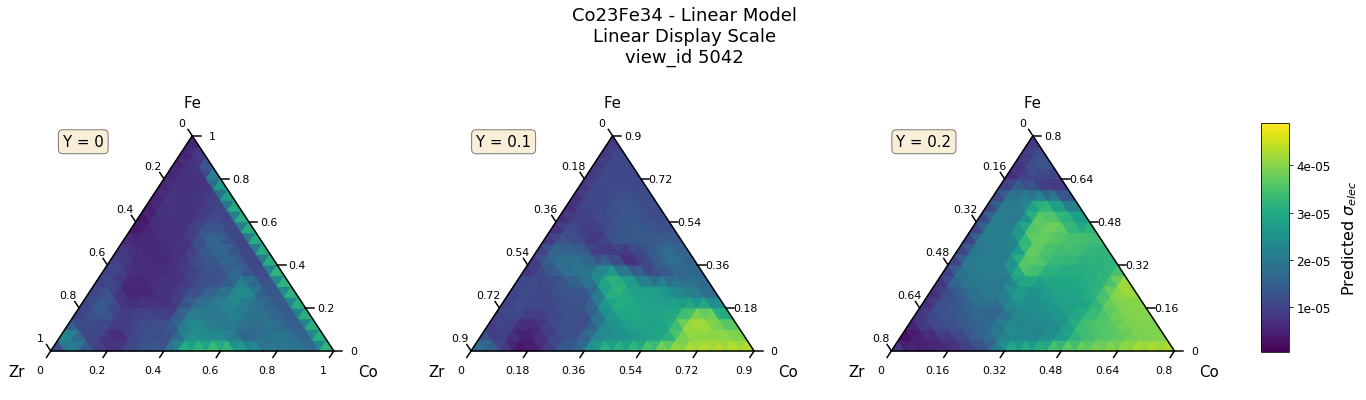

In [190]:
fig, axes = pred_sigma_slice_plots(slice_axis='Y',tern_labels=['Co','Fe','Zr'],slice_vals=[0,0.1,0.2],
                                   zdict=sigma_5042_dict,zfunc=slicetup_lookup,
                                   title='Co23Fe34 - Linear Model\nLinear Display Scale\nview_id 5042',
                                   logscale=False)

-5.4 -4.310087340299119


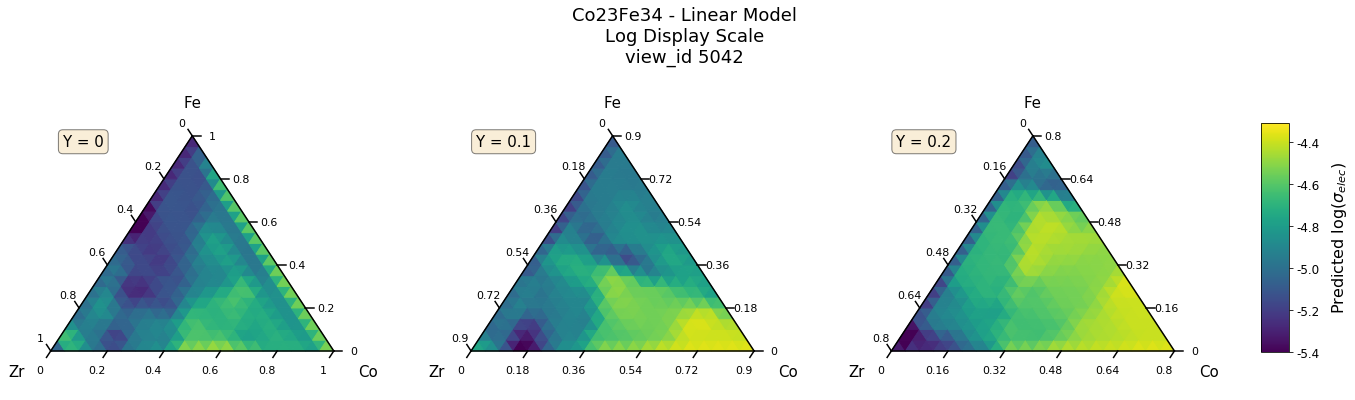

In [191]:
fig, axes = pred_sigma_slice_plots(slice_axis='Y',tern_labels=['Co','Fe','Zr'],slice_vals=[0,0.1,0.2],
                                   zdict=sigma_5042_dict,zfunc=log_st_lookup, vmin=-5.4,
                                   title='Co23Fe34 - Linear Model\nLog Display Scale\nview_id 5042',
                                   logscale=True)

-10.5 -4


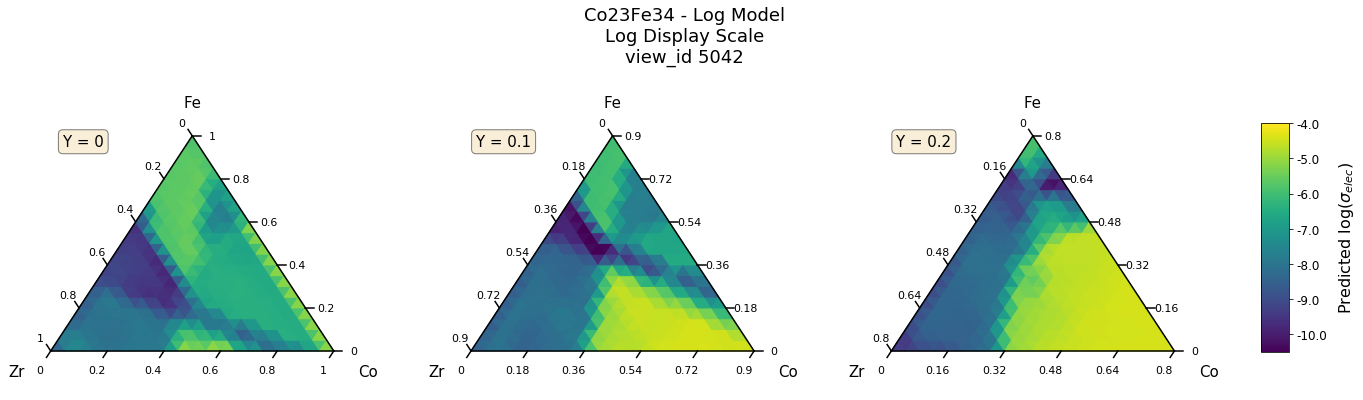

In [202]:
fig, axes = pred_sigma_slice_plots(slice_axis='Y',tern_labels=['Co','Fe','Zr'],slice_vals=[0,0.1,0.2],
                                   zdict=logsigma_5042_dict,zfunc=slicetup_lookup, vmin = -10.5, vmax=-4,
                                   title='Co23Fe34 - Log Model\nLog Display Scale\nview_id 5042',
                                   logscale=True)
plt.savefig(os.path.join(plotdir,'pred_logsigma5042_sliceY.png'),dpi=500)

-10.5 -4


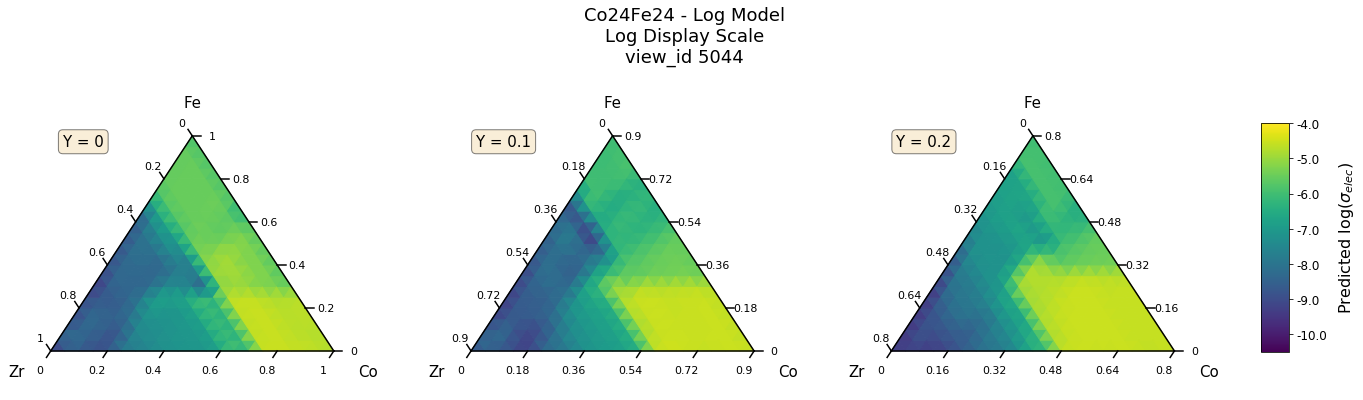

In [204]:
fig, axes = pred_sigma_slice_plots(slice_axis='Y',tern_labels=['Co','Fe','Zr'],slice_vals=[0,0.1,0.2],
                                   zdict=logsigma_5044_dict,zfunc=slicetup_lookup, vmin = -10.5, vmax=-4,
                                   title='Co24Fe24 - Log Model\nLog Display Scale\nview_id 5044',
                                   logscale=True)
plt.savefig(os.path.join(plotdir,'pred_logsigma5044_sliceY.png'),dpi=500)

-10.5 -4


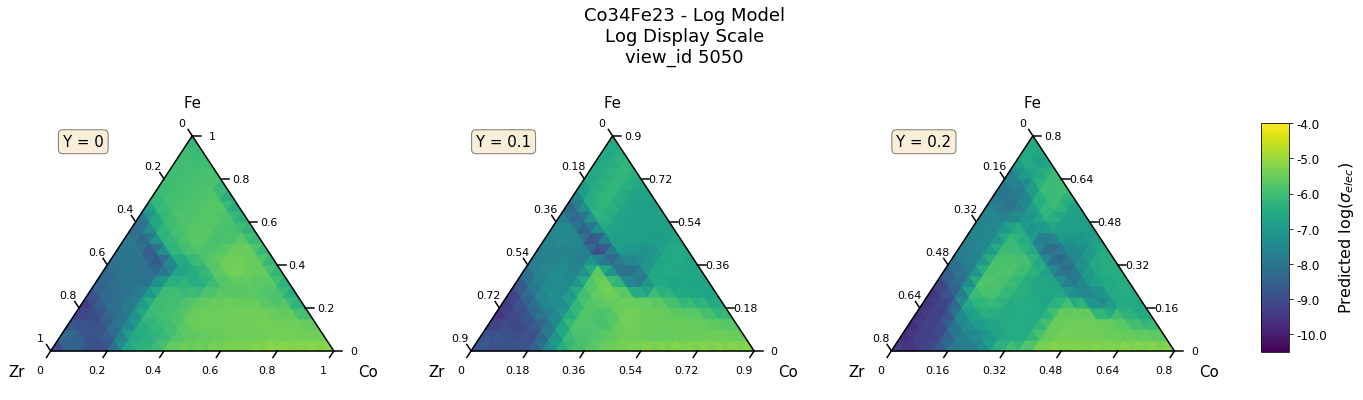

In [205]:
fig, axes = pred_sigma_slice_plots(slice_axis='Y',tern_labels=['Co','Fe','Zr'],slice_vals=[0,0.1,0.2],
                                   zdict=logsigma_5050_dict,zfunc=slicetup_lookup, vmin = -10.5, vmax=-4,
                                   title='Co34Fe23 - Log Model\nLog Display Scale\nview_id 5050',
                                   logscale=True)
plt.savefig(os.path.join(plotdir,'pred_logsigma5050_sliceY.png'),dpi=500)

### Zr slices

-5.4 -4.310087340299119


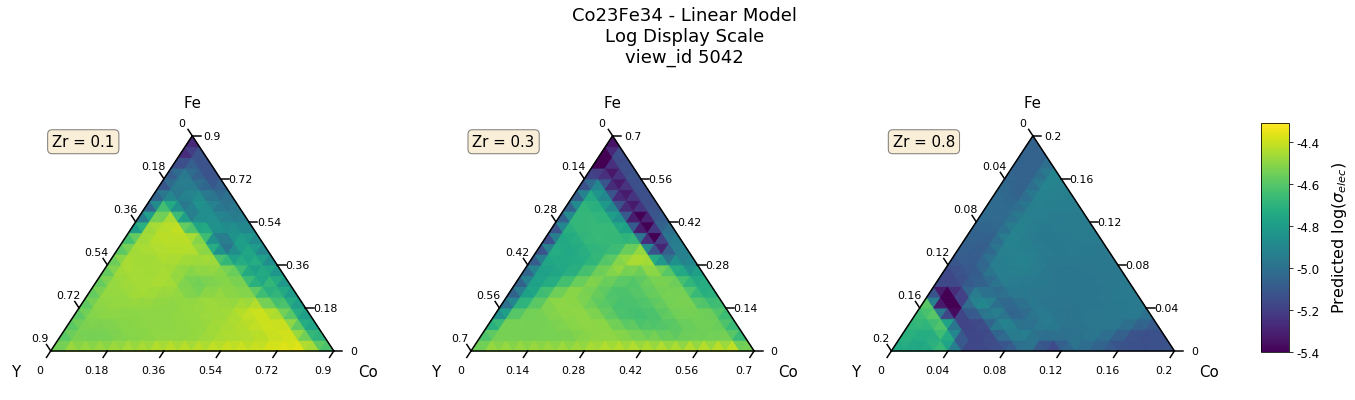

In [196]:
fig, axes = pred_sigma_slice_plots(slice_axis='Zr',tern_labels=['Co','Fe','Y'],slice_vals=[0.1,0.3,0.8],
                                   zdict=sigma_5042_dict,zfunc=log_st_lookup,vmin=-5.4,
                                   title='Co23Fe34 - Linear Model\nLog Display Scale\nview_id 5042',
                                   logscale=True)

-10.5 -4


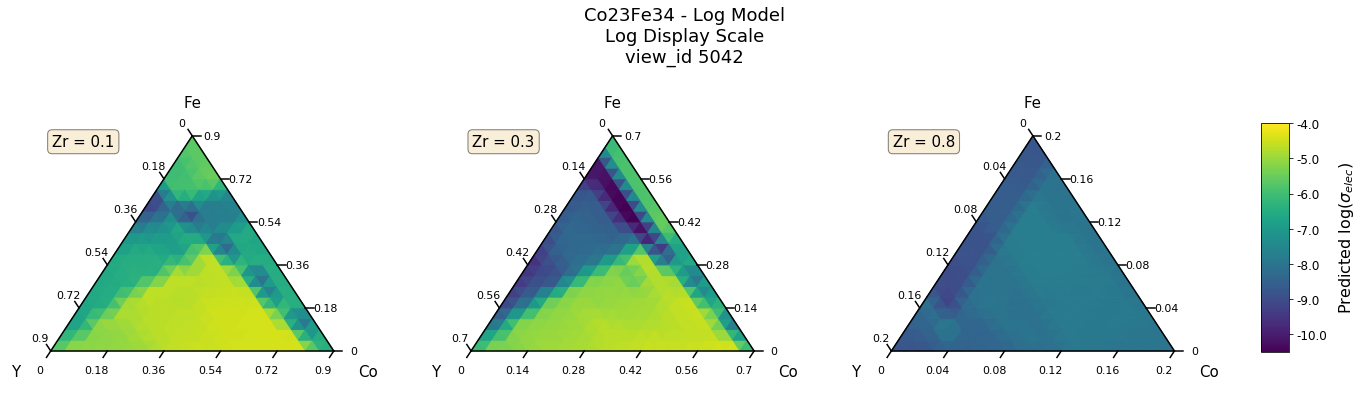

In [197]:
fig, axes = pred_sigma_slice_plots(slice_axis='Zr',tern_labels=['Co','Fe','Y'],slice_vals=[0.1,0.3,0.8],
                                   zdict=logsigma_5042_dict,zfunc=slicetup_lookup,vmin=-10.5,vmax=-4,
                                   title='Co23Fe34 - Log Model\nLog Display Scale\nview_id 5042',
                                   logscale=True)
plt.savefig(os.path.join(plotdir,'pred_logsigma5042_sliceZr.png'),dpi=500)

-10.5 -4


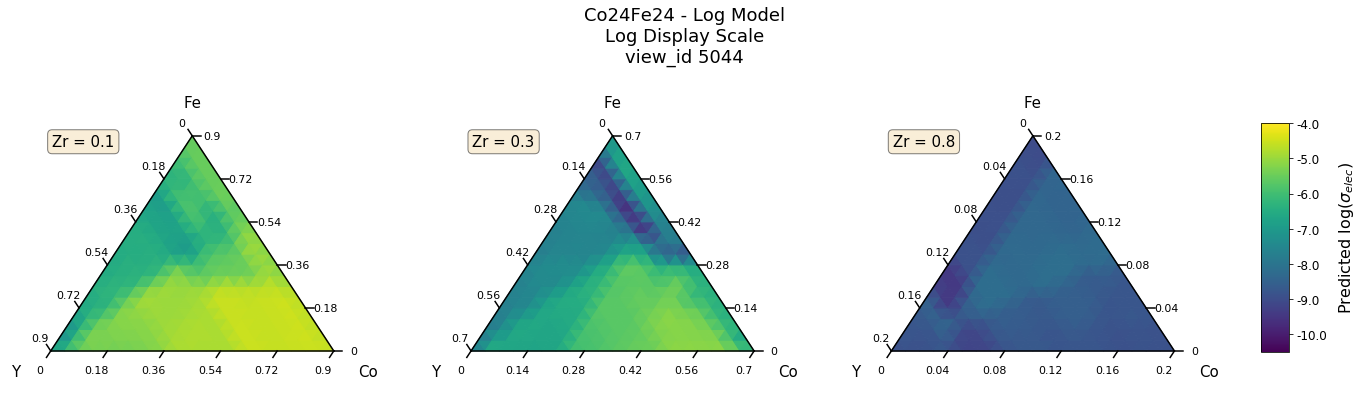

In [198]:
fig, axes = pred_sigma_slice_plots(slice_axis='Zr',tern_labels=['Co','Fe','Y'],slice_vals=[0.1,0.3,0.8],
                                   zdict=logsigma_5044_dict,zfunc=slicetup_lookup,vmin=-10.5,vmax=-4,
                                   title='Co24Fe24 - Log Model\nLog Display Scale\nview_id 5044',
                                   logscale=True)
plt.savefig(os.path.join(plotdir,'pred_logsigma5044_sliceZr.png'),dpi=500)

-10.5 -4


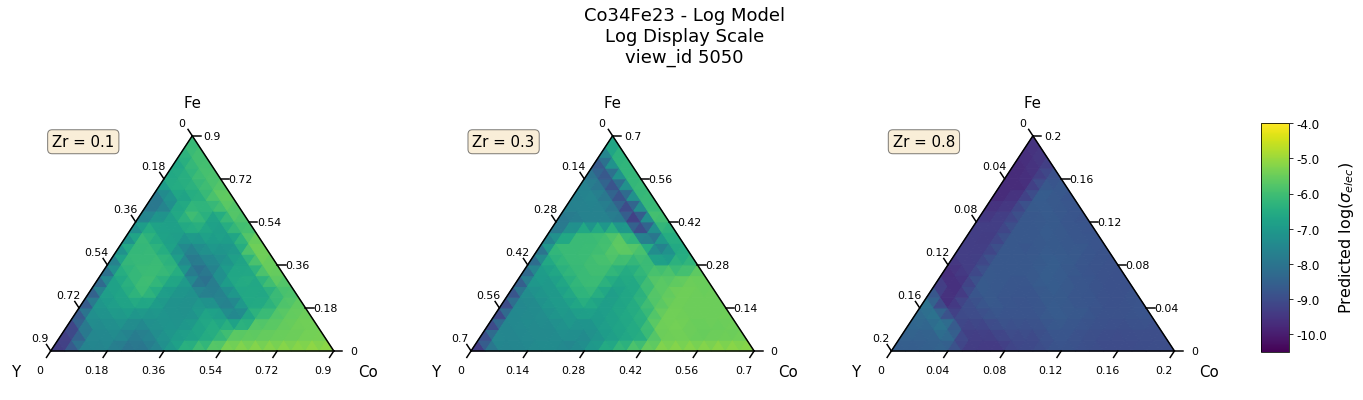

In [199]:
fig, axes = pred_sigma_slice_plots(slice_axis='Zr',tern_labels=['Co','Fe','Y'],slice_vals=[0.1,0.3,0.8],
                                   zdict=logsigma_5050_dict,zfunc=slicetup_lookup,vmin=-10.5,vmax=-4,
                                   title='Co34Fe23 - Log Model\nLog Display Scale\nview_id 5050',
                                   logscale=True)
plt.savefig(os.path.join(plotdir,'pred_logsigma5050_sliceZr.png'),dpi=500)

In [175]:
vmins, vmaxes

([1.6979715200498787e-06, 5.430368406545792e-07, 3.0427113308637804e-06],
 [4.172843559905602e-05, 4.896803306028625e-05, 4.486924770992365e-05])

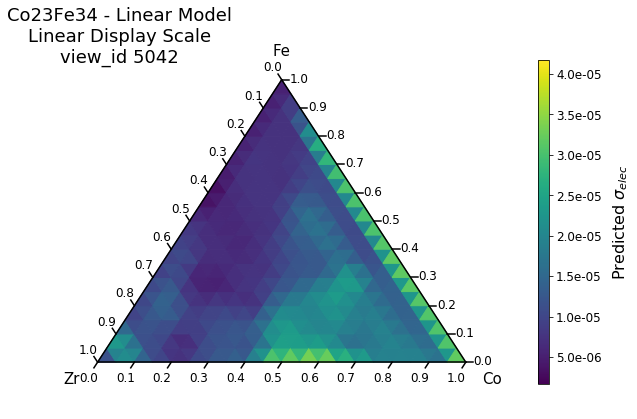

In [124]:
tax, vmin, vmax = quat_slice_heatmap(tuple_scale=20,zfunc=slicetup_lookup,slice_val=0,
                                     zfunc_kwargs={'dict':sigma_5042_dict,'slice_val':0},
                                    figsize=(7.5,6), labelsize=15,
                                     tick_kwargs={'tick_formats': '%.1f', 'offset': 0.02,'fontsize':12} )

plt.title('Co23Fe34 - Linear Model\nLinear Display Scale\nview_id 5042',size='18',x=0.1)

add_colorbar(vmin=vmin,vmax=vmax,label='Predicted $\sigma_{elec}$',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1e')

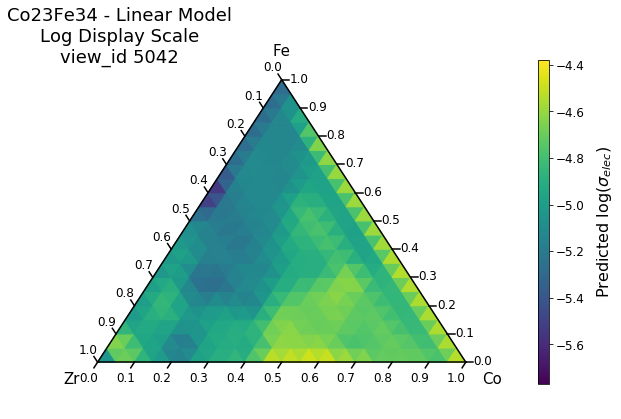

In [126]:
tax, vmin, vmax = quat_slice_heatmap(tuple_scale=20,zfunc=log_st_lookup,slice_val=0,
                                     zfunc_kwargs={'dict':sigma_5042_dict,'slice_val':0},
                                    figsize=(7.5,6), labelsize=15,
                                     tick_kwargs={'tick_formats': '%.1f', 'offset': 0.02,'fontsize':12} )

plt.title('Co23Fe34 - Linear Model\nLog Display Scale\nview_id 5042',size='18',x=0.1)

add_colorbar(vmin=vmin,vmax=vmax,label='Predicted log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12})

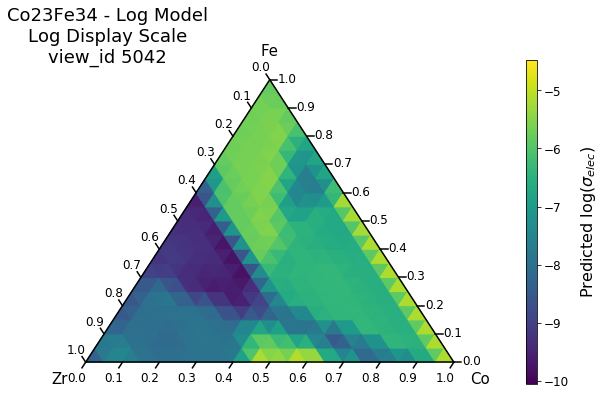

In [127]:
tax, vmin, vmax = quat_slice_heatmap(tuple_scale=20,zfunc=slicetup_lookup,slice_val=0,
                                     zfunc_kwargs={'dict':logsigma_5042_dict,'slice_val':0},
                                    figsize=(7.5,6), labelsize=15,
                                     tick_kwargs={'tick_formats': '%.1f', 'offset': 0.02,'fontsize':12} )

plt.title('Co23Fe34 - Log Model\nLog Display Scale\nview_id 5042',size='18',x=0.1)

add_colorbar(vmin=vmin,vmax=vmax,label='Predicted log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12})

In [210]:
print (ternary.__file__)

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ternary\__init__.py


In [45]:
calc_feat_Co23Fe34 = pickle_dict(os.path.join(pickledir,'feat_Co23Fe34'))

In [48]:
calc_feat_Co23Fe34.dict = cf2334

In [49]:
calc_feat_Co23Fe34.dict

{'Ba0.9Co0.045Fe0.045Zr0.81Y0.1O3': {'A:B_ratio': 0.9,
  'A_sum': 0.9,
  'B_sum': 1.0,
  'Ba_amt': 0.9,
  'Co:Fe_ratio': 1.0,
  'Co_amt': 0.045,
  'Fe_amt': 0.045,
  'MO_ABE': -416.9950625000001,
  'MO_IC_a': 0.8032113561415081,
  'MO_IC_avg': 0.7260828203938751,
  'MO_IC_b': 0.6566671382210052,
  'X_a': 0.89,
  'X_avg': 1.1406578947368422,
  'X_b': 1.36625,
  'X_cat_a_oxavg': 0.7715751707110065,
  'X_cat_b_oxavg': 7.308085391172874,
  'Y_amt': 0.1,
  'Zr_amt': 0.81,
  'acceptor_magnitude': -0.1,
  'alat_oxavg': 4.263433205685754,
  'goldschmidt_oxavg': 0.998608443251001,
  'mass_a': 137.327,
  'mass_avg': 111.33754935526318,
  'mass_b': 87.94704377500001,
  'n_a_oxavg': 2.0,
  'n_b_oxavg': 3.8100000000000005,
  'r_a_oxavg': 1.61,
  'r_b_oxavg': 0.7313624999999999,
  'r_b_std_oxavg': 0.06252616852793025,
  'r_crit_oxavg': 0.9202591343849977,
  'tau_oxavg': 3.4939428368742917,
  'tot_cat_charge_oxavg': 5.61,
  'trans_met_amt': 0.09,
  'uc_vol_free_oxavg': 26.135730596640244,
  'uc_vol_o

In [50]:
calc_feat_Co23Fe34.save()

Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co23Fe34


In [19]:
test.dict

{'a': 1, 'b': 2}

In [20]:
test.dict['c'] = 3

In [21]:
test.dict

{'a': 1, 'b': 2, 'c': 3}

In [23]:
test.save()

Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\test


In [24]:
t2 = pickle_dict(file)
t2.dict

{'a': 1, 'b': 2, 'c': 3}

In [42]:
help(pickle_dict)

Help on class pickle_dict in module helpers.pickletools:

class pickle_dict(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, file)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  reload(self)
 |      reload dict from file. Overwrites dict
 |  
 |  save(self, file=None)
 |  
 |  set_file(self, file)
 |      change file that dict is saved to/loaded from
 |  
 |  update(self)
 |      update dict from file
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  file



In [111]:
help(add_colorbar)

NameError: name 'add_colorbar' is not defined